# Introduction
This task consists in compare two sentences present on the dataset and identify if both have the same meaning.<br>
An Exploratory Data Analysis is made to gain insights about the data, a Topic Modelling to get the features and the classification step, these last two steps are made with the Python Module PyCaret.<br>
Importing the requires modules, PyCaret is imported later to avoid conflicts on the experiments.

In [331]:
# Standard
import pandas as pd
import sidetable
# Plots
from plotly.offline import init_notebook_mode, iplot
import plotly.graph_objects as go
from plotly.subplots import make_subplots
init_notebook_mode(connected=True)
import seaborn as sns
# Sklearn tools
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import *

path = '/home/jovyan/'
rnd_seed = 1142

The helper functions used to plots, data sampling and scores.

In [332]:
## Dataset Sampling
def data_sampling(dataset, frac: float, random_seed: int):
    data_sampled_a = dataset.sample(frac=frac, random_state=random_seed)
    data_sampled_b =  dataset.drop(data_sampled_a.index).reset_index(drop=True)
    data_sampled_a.reset_index(drop=True, inplace=True)
    return data_sampled_a, data_sampled_b  
## Pie Chart
def pie_plot(data, plot_title: str):
    trace = go.Pie(labels=data.index, values=data.values)
    layout = go.Layout(autosize=False,
    title={"text" : plot_title,
            "y" : 0.9,
            "x" : 0.5,
            "xanchor" : "center",
            "yanchor" : "top"})
    fig = go.Figure(data=trace, layout=layout)
    fig.update_traces(textfont_size=14,
                      marker=dict(line=dict(color="#000000",
                      width=2)))
    fig.update_yaxes(automargin=True)
    iplot(fig)
## Histogram subplots
def histogram_subplot(dataset_a, dataset_b, feature_a: str,
feature_b: str, title: str, title_a:
str, title_b: str):
    fig = make_subplots(rows=1, cols=2, subplot_titles=(
    title_a,
    title_b
    )
    )
    fig.add_trace(go.Histogram(x=dataset_a[feature_a],
    showlegend=False), row=1, col=1)
    fig.add_trace(go.Histogram(x=dataset_b[feature_b],
    showlegend=False), row=1, col=2)
    fig.update_layout(template="simple_white")
    fig.update_layout(autosize=False,
    title={"text" : title,
            "y" : 0.9,
            "x" : 0.5,
            "xanchor" : "center",
            "yanchor" : "top"},
            yaxis={"title" : "<i>Frequency</i>"})
    fig.update_traces(marker=dict(line=dict(color="#000000",
    width=2)))
    fig.update_yaxes(automargin=True)
    iplot(fig)
# Calculate scores with Test/Unseen labeled data
def test_score_report(data_unseen, predict_unseen):
    le = LabelEncoder()
    data_unseen["Label"] = le.fit_transform(data_unseen.same_security.values)
    data_unseen["Label"] = data_unseen["Label"].astype(int)
    accuracy = accuracy_score(data_unseen["Label"],
    predict_unseen["Label"])
    roc_auc = roc_auc_score(data_unseen["Label"],
    predict_unseen["Label"])
    precision = precision_score(data_unseen["Label"],
    predict_unseen["Label"])
    recall = recall_score(data_unseen["Label"],
    predict_unseen["Label"])
    f1 = f1_score(data_unseen["Label"],
    predict_unseen["Label"])
    df_unseen = pd.DataFrame({
    "Accuracy" : [accuracy],
    "AUC" : [roc_auc],
    "Recall" : [recall],
    "Precision" : [precision],
    "F1 Score" : [f1]
    })
    return df_unseen
# Confusion Matrix
def conf_mat(data_unseen, predict_unseen):
    unique_label = data_unseen["Label"].unique()
    cmtx = pd.DataFrame(
    confusion_matrix(data_unseen["Label"],
                    predict_unseen["Label"], labels=unique_label),
                    index=['{:}'.format(x) for x in unique_label],
                    columns=['{:}'.format(x) for x in unique_label])
    ax = sns.heatmap(cmtx, annot=True, fmt="d", cmap="YlGnBu")
    ax.set_ylabel('Predicted')
    ax.set_xlabel('Target');
    ax.set_title("Predict Unseen Confusion Matrix", size=14);

# 1. Data Loading and Initial Infos
The data is loaded in a Dataframe

In [333]:
data = pd.read_csv(path+'data/train.csv')
data.head(3)

,Unnamed: 0,description_x,description_y,ticker_x,ticker_y,same_security
0,0,first trust dow jones internet,first trust dj internet idx,FDN,FDN,True
1,1,schwab intl large company index etf,schwab strategic tr fundamental intl large co ...,FNDF,FNDF,True
2,2,vanguard small cap index adm,vanguard small-cap index fund inst,VSMAX,VSCIX,False


A check for duplicated samples.

In [334]:
data.drop_duplicates(inplace=True, keep='first')

There're no duplicated samples on the dataset.<br>
Time to drop features that will not help on the prediction and get some information about the data.

In [335]:
data.drop(columns=['Unnamed: 0', 'ticker_x', 'ticker_y'], inplace=True)
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2142 entries, 0 to 2141
Data columns (total 3 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   description_x  2142 non-null   object
 1   description_y  2142 non-null   object
 2   same_security  2142 non-null   bool  
dtypes: bool(1), object(2)
memory usage: 52.3+ KB


And check for missing values.

In [336]:
data.stb.missing()

,missing,total,percent
description_x,0,2142,0.0
description_y,0,2142,0.0
same_security,0,2142,0.0


The dataset doesn't contain any missing value, what is very good!
A good approach to compare the sentences is check its characters length, let's create these features for each sentence.

In [337]:
data['len_x'] = data['description_x'].apply(len)
data['len_y'] = data['description_y'].apply(len)

# 2. EDA

Let's check the distribution of the target feature, `same_security`.

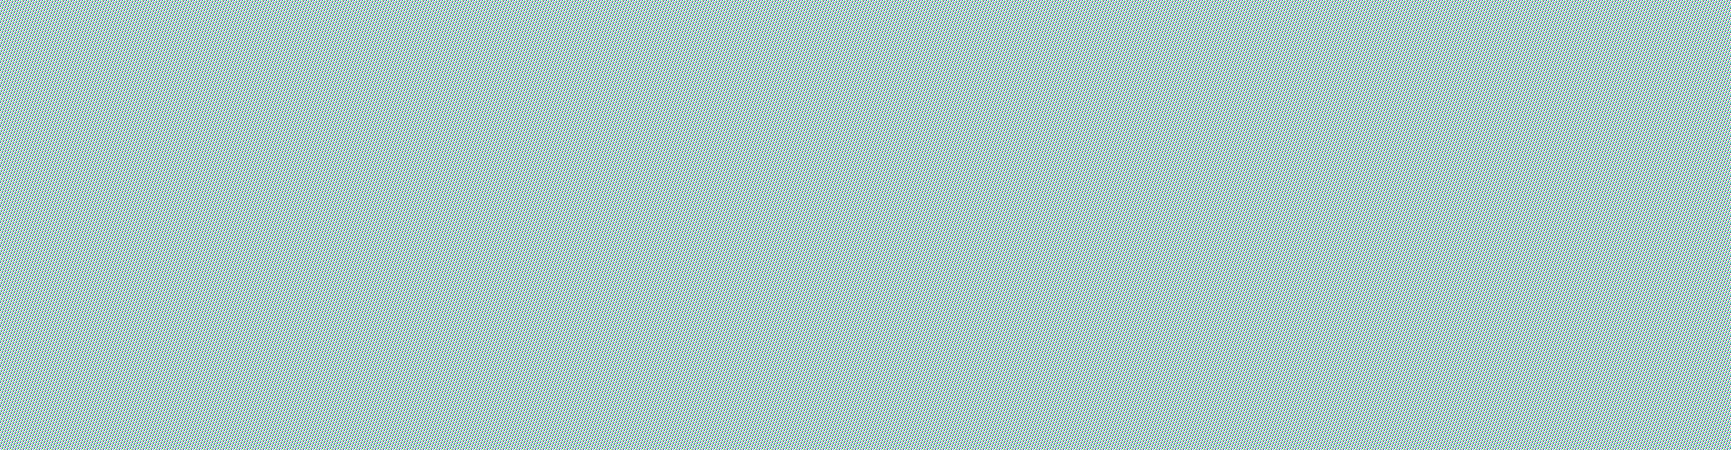

In [338]:
series_aux = data['same_security'].value_counts()
pie_plot(series_aux, 'Security Values')

It's a case of imbalanced classes and it will be handled with a model evaluation using F1-Score. I will not use any resampling technique, as random oversampling, SMOTE, etc. <br>
A good insight for this problem is see the distribution of character length of each sentence for the security values, starting with the True values.

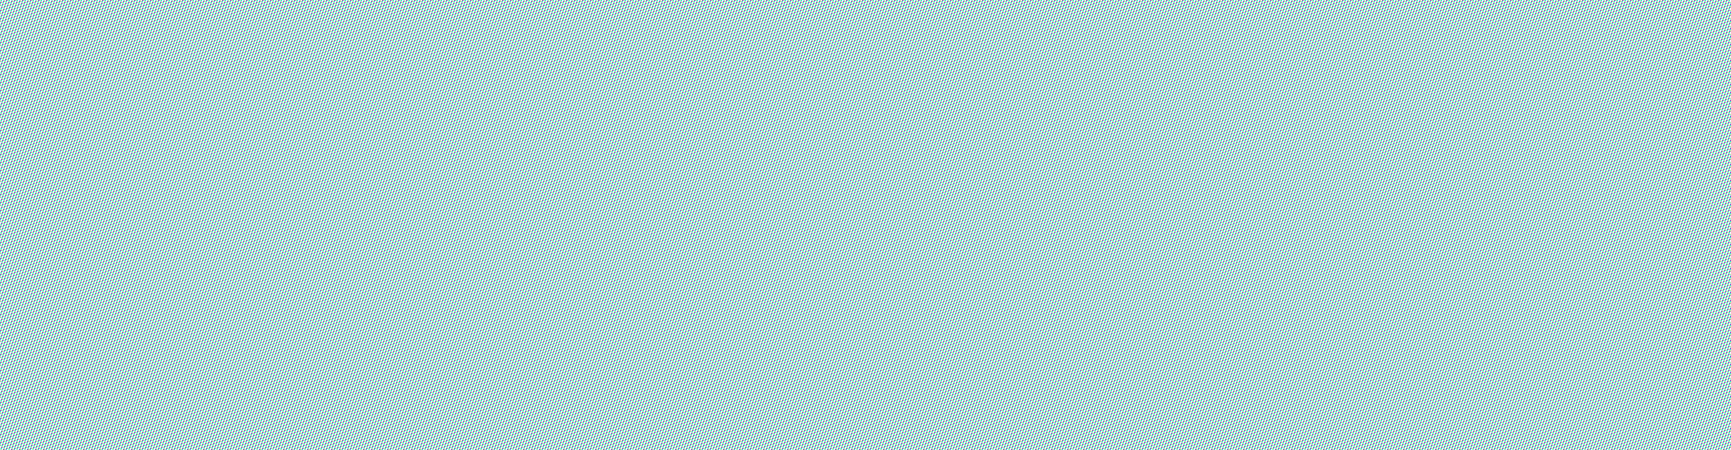

In [339]:
data_true = data.query('same_security == True')
histogram_subplot(data_true, data_true, 'len_x', 'len_y', 
                  '<b>Character length distribution for True Security', 
                  'Description X Length', 'Description Y Length')

Sentences that are True on the comparing, have a similar distribution, even on the frequency for the values, for now, seems a good idea use the character length as a feature.<br>
To make this idea better, let's check it for the False values.

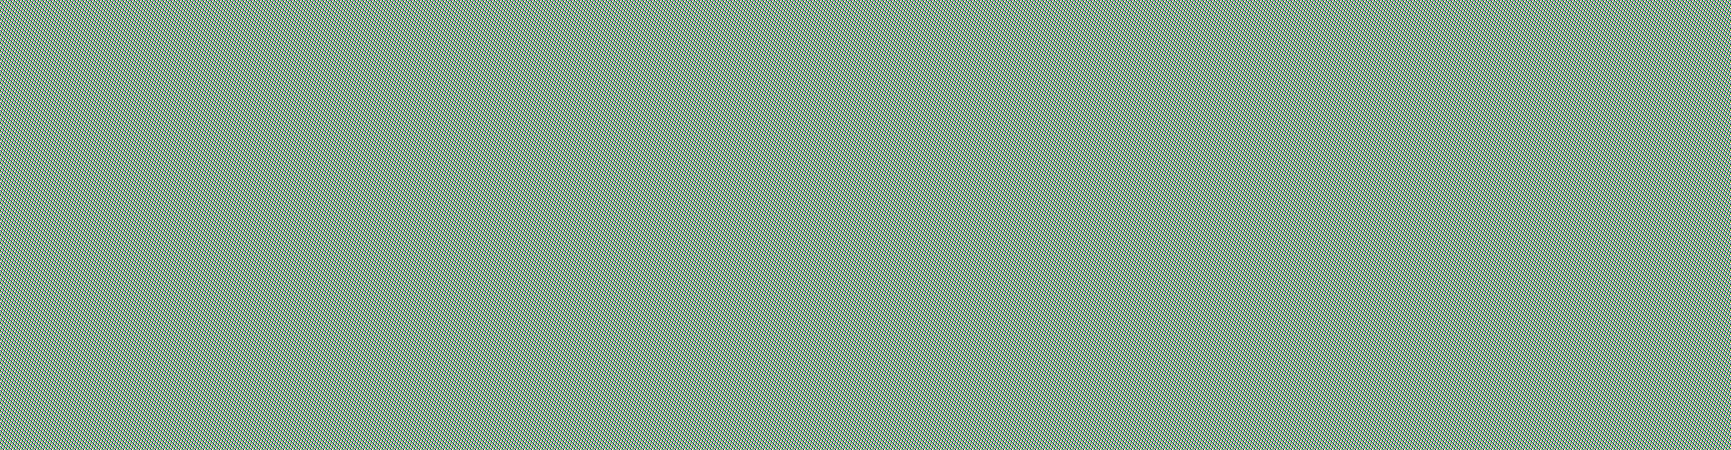

In [340]:
data_false = data.query('same_security == False')
histogram_subplot(data_false, data_false, 'len_x', 'len_y', 
                  '<b>Character length distribution for False Security', 
                  'Description X Length', 'Description Y Length')

And for the False values the distribution for each sentence is different, I will use both features about the character length to feed the model.

# 3. Model Build
PyCaret has a NLP module that can automatize most of the boring stuff, like lowering case, remove stop words, stemming, etc. So, a good amount of this part is just setting up PyCaret to run.<br>
Let's import the module.

In [341]:
from pycaret.nlp import *

The english words package from Spacy is needed to run PyCaret NLP module.

In [342]:
#!python -m spacy download en

The PyCaret setup is simple, just enter data, the text target to process and a random seed for the session.<br>
It's possible to add custom stop words, but I will use the default from PyCaret.<br>
Let's start with the text from `description_x`.

In [343]:
import spacy
spacy.load('en')
exp_x = setup(data=data, target='description_x', session_id=rnd_seed)

Description,Value
session_id,1142
# Documents,2142
Vocab Size,280
Custom Stopwords,False


280 words are present in the vocabulary for `sentence_x`.<br>
To get the features for the model, is used a Topic Modelling witg PyCaret, for it, the model is tuned (LDA Model) to see what is the best number of topics.

IntProgress(value=0, description='Processing: ', max=25)

Output()

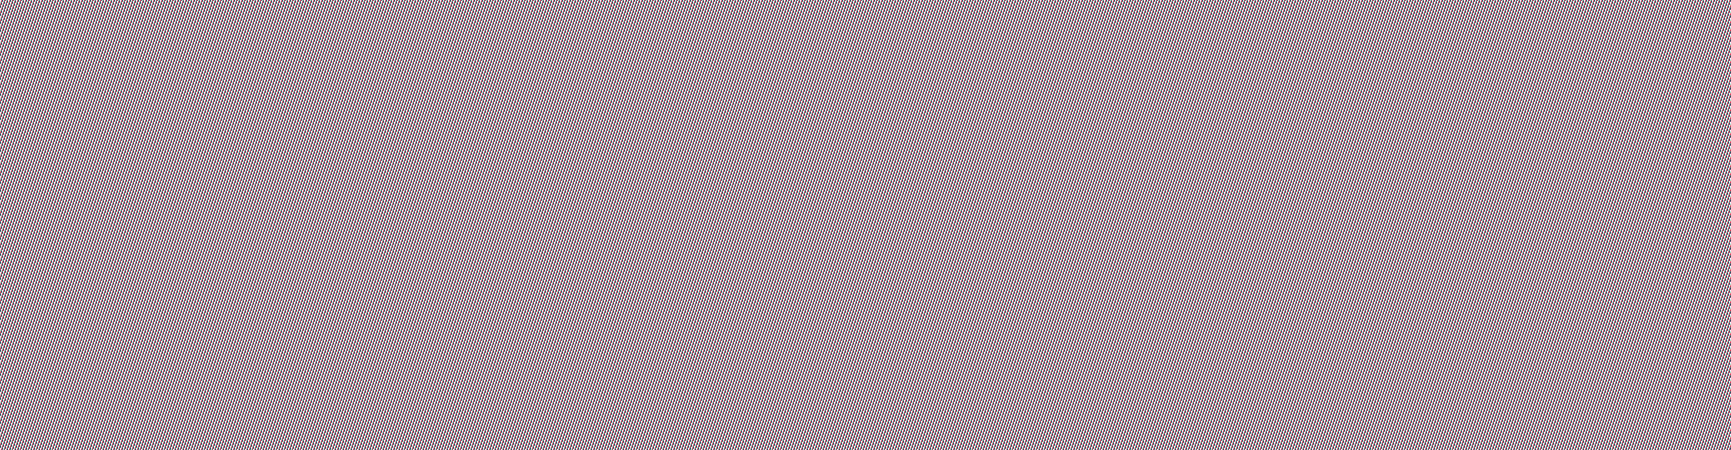

Best Model: Latent Dirichlet Allocation | # Topics: 100 | Accuracy : 0.8641


In [344]:
tuned_model_x = tune_model(model='lda', supervised_target='same_security')

Based on the F1-Score, the model doesn't have a high variation on the score, so I will use 4 topics, to keep it simples.<br>
Time to create a LDA model with 4 topics and see some informations about the topic modelled data.<br>
You can click on each box to see infos like frequency of a word, word cloud, etc.<br>

In [345]:
model_x = create_model('lda', num_topics=4)

In [346]:
evaluate_model(model_x)

interactive(children=(ToggleButtons(description='Plot Type:', icons=('',), options=(('Frequency Plot', 'freque…

The model is assigned to the topic weights and other infos to use after in the classification task.

In [347]:
model_x_results = assign_model(model_x)

Now, all the steps are made again for the `description_y`.

In [348]:
exp_y = setup(data=data, target='description_y', session_id=rnd_seed)

Description,Value
session_id,1142
# Documents,2142
Vocab Size,286
Custom Stopwords,False


286 words are present in the vocabulary for `sentence_y`.

IntProgress(value=0, description='Processing: ', max=25)

Output()

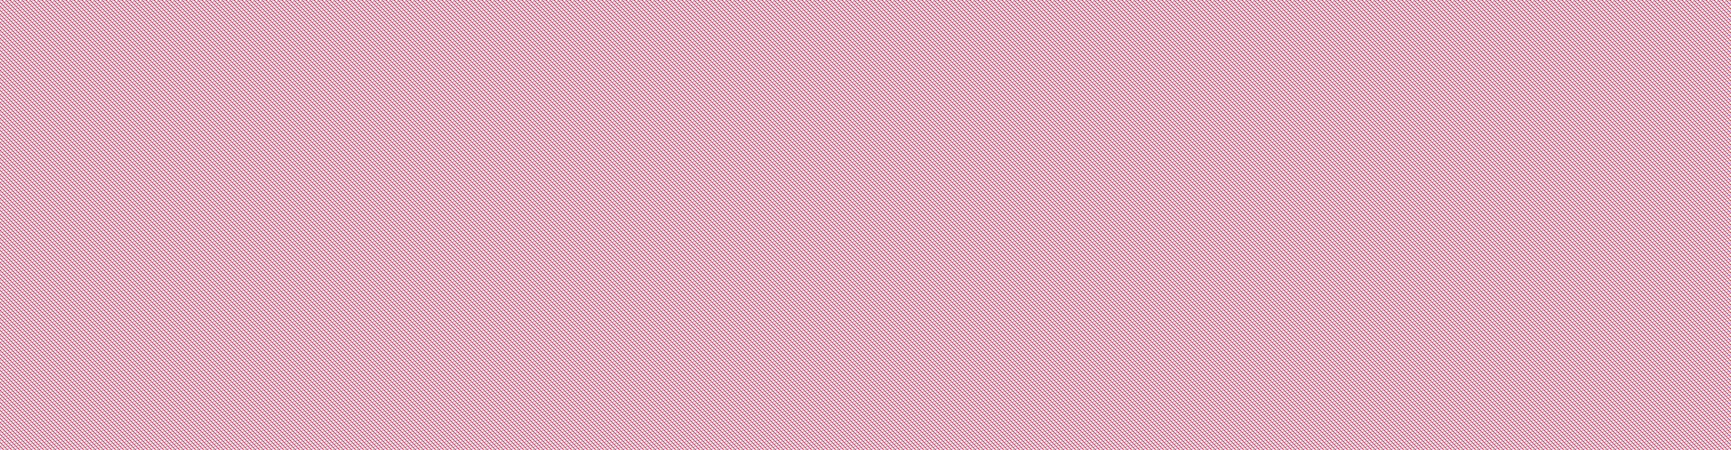

Best Model: Latent Dirichlet Allocation | # Topics: 100 | Accuracy : 0.8464


In [349]:
tuned_model_y = tune_model(model='lda', supervised_target='same_security')

The result from the tuned model is similar from before, so 4 topics is used again.

In [350]:
model_y = create_model('lda', num_topics=4)

If you need, it's possible to see the evaluation of this second model, but unfortunately it will bug the evaluate from the `description_x`.

In [351]:
#evaluate_model(model_y)

In [352]:
model_y_results = assign_model(model_y)

Topic Modelling made and is time to make the classification.

# 4. Classification
To start, the unused columns are dropped and the results are concatenated in one dataframe.

In [353]:
data_topics = model_x_results.drop(columns=['description_x', 'description_y', 
                                         'Dominant_Topic', 'Perc_Dominant_Topic'])
data_topics['Topic_0_y'] = model_y_results['Topic_0']
data_topics['Topic_1_y'] = model_y_results['Topic_1']
data_topics['Topic_2_y'] = model_y_results['Topic_2']
data_topics['Topic_3_y'] = model_y_results['Topic_3']

To avoid errors with PyCaret on the label feature, `same_security` is converted to object and the labels are renamed to `Yes` for `True` and `No` for `False`.<br>
10% of the data is sampled to be used as unseen data to validate the final model.

In [354]:
from pycaret.classification import *

data_topics['same_security'] = data_topics['same_security'].astype('str')
data_topics_dict = {'True' : 'Yes',  'False' : 'No'}
data_topics['same_security'] = data_topics['same_security'].replace(data_topics_dict)
train, unseen = data_sampling(data_topics, 0.9, rnd_seed)
data_topics.head(5)

,same_security,len_x,len_y,Topic_0,Topic_1,Topic_2,Topic_3,Topic_0_y,Topic_1_y,Topic_2_y,Topic_3_y
0,Yes,30,27,0.214068,0.223597,0.381175,0.18116,0.103033,0.246803,0.538714,0.111450
1,Yes,35,55,0.419814,0.240854,0.287801,0.05153,0.029652,0.782703,0.036272,0.151373
2,No,28,34,0.131389,0.137238,0.620183,0.11119,0.072919,0.759031,0.089174,0.078876
3,Yes,53,60,0.214068,0.223597,0.381175,0.18116,0.175450,0.420206,0.214561,0.189783
4,Yes,16,9,0.214068,0.223597,0.381175,0.18116,0.175450,0.420206,0.214561,0.189783


The same setting up from before, but now PyCaret split the dataset in 70% for Train and 30% for Test.<br>
No feature transformation, scalling or normalization are used.

In [355]:
exp_clf = setup(data=train, target='same_security', session_id=rnd_seed)

 
Setup Succesfully Completed!


,Description,Value
0,session_id,1142
1,Target Type,Binary
2,Label Encoded,"No: 0, Yes: 1"
3,Original Data,"(1928, 11)"
4,Missing Values,False
5,Numeric Features,10
6,Categorical Features,0
7,Ordinal Features,False
8,High Cardinality Features,False
9,High Cardinality Method,None


Compare the models sorted by F1-Score to get the best.`

In [356]:
compare_models(sort='F1')

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa
0,CatBoost Classifier,0.829500,0.827200,0.933800,0.853800,0.891600,0.494600
1,Light Gradient Boosting Machine,0.828000,0.817100,0.922900,0.859100,0.889600,0.501800
2,Gradient Boosting Classifier,0.821400,0.807800,0.939700,0.842000,0.887800,0.455300
3,Extreme Gradient Boosting,0.816900,0.804000,0.938700,0.837500,0.885000,0.442400
4,Ada Boost Classifier,0.815500,0.777900,0.933800,0.839100,0.883700,0.442800
5,Random Forest Classifier,0.805100,0.798400,0.873500,0.868900,0.870800,0.472900
6,Ridge Classifier,0.776200,0.000000,0.964400,0.786200,0.866100,0.224900
7,Extra Trees Classifier,0.793200,0.788400,0.886300,0.846600,0.865500,0.416800
8,Linear Discriminant Analysis,0.777600,0.732100,0.950600,0.794200,0.865200,0.258300
9,Logistic Regression,0.774700,0.735100,0.959500,0.787300,0.864700,0.227300


The best model by F1-Score is the Catboost Classifier, let's create a base model.

In [357]:
base_model = create_model('catboost')

,Accuracy,AUC,Recall,Prec.,F1,Kappa
0,0.8222,0.8139,0.9118,0.8611,0.8857,0.4872
1,0.8370,0.8345,0.9608,0.8448,0.8991,0.4849
2,0.8148,0.7868,0.9604,0.8220,0.8858,0.4109
3,0.8444,0.8867,0.9406,0.8636,0.9005,0.5475
4,0.7778,0.7471,0.9208,0.8087,0.8611,0.3170
5,0.8444,0.8588,0.9307,0.8704,0.8995,0.5570
6,0.8148,0.7631,0.9406,0.8333,0.8837,0.4372
7,0.8370,0.8480,0.9010,0.8835,0.8922,0.5590
8,0.8519,0.8720,0.9406,0.8716,0.9048,0.5736
9,0.8507,0.8608,0.9307,0.8785,0.9038,0.5717


And the tune this base model to see if can get any improvement.

In [358]:
tuned_model = tune_model('catboost', optimize='F1')

,Accuracy,AUC,Recall,Prec.,F1,Kappa
0,0.8444,0.7886,0.9706,0.8462,0.9041,0.5024
1,0.8148,0.7864,0.9510,0.8291,0.8858,0.4076
2,0.7704,0.7515,0.9505,0.7869,0.8610,0.2337
3,0.8519,0.8427,0.9604,0.8584,0.9065,0.5547
4,0.7778,0.7381,0.9406,0.7983,0.8636,0.2847
5,0.8370,0.8071,0.9406,0.8559,0.8962,0.5208
6,0.8074,0.7899,0.9604,0.8151,0.8818,0.3801
7,0.8074,0.8002,0.9208,0.8378,0.8774,0.4337
8,0.7852,0.8135,0.9604,0.7951,0.8700,0.2831
9,0.8358,0.8308,0.9604,0.8435,0.8981,0.4841


No improvements on the tuned model, let's stick with the base model to predict the test data.

In [359]:
predict_model(base_model);

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa
0,CatBoost Classifier,0.8756,0.8737,0.9654,0.8803,0.9209,0.6334


And the results are good! As the test data is well fitted on the model, let's use it to fit a final model.

In [360]:
final_model = finalize_model(base_model)

And the Features importance of the Final Model.

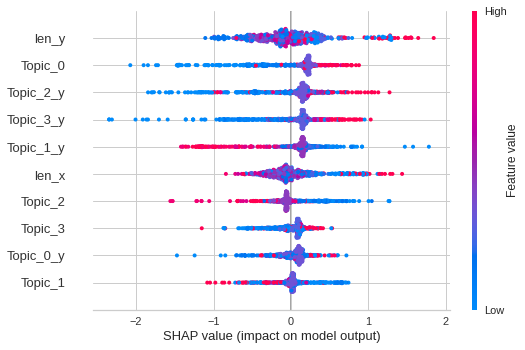

In [363]:
interpret_model(final_model)

The length on the `sentence_y` had a high impact on model prediction performance.

# 5. Validation on Unseen Data
To validadte the model, let's see the prediction with unseen data, which was not included on the final model fit.

 Accuracy       AUC    Recall  Precision  F1 Score
 0.892523  0.808829  0.958084   0.909091  0.932945


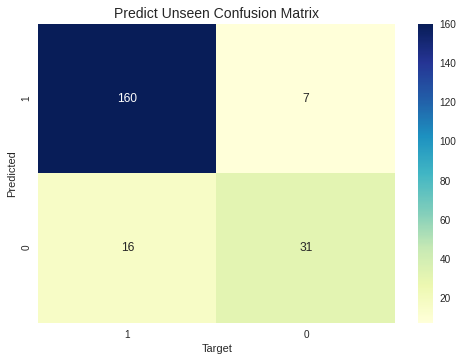

In [361]:
predict_unseen = predict_model(final_model, data=unseen);
score_unseen = test_score_report(unseen, predict_unseen)
print(score_unseen.to_string(index=False))
conf_mat(unseen, predict_unseen);

So, the unseen data was well predicted on the model, with a high F1-Score showing a good balance between Recall and precision.

# 6. Conclusion
The following conclusions can be drawed:
* The Model just needed 4 Topics Modelled to compare the sentences.
* Character length is important to compare the sentences.
* Recall was excellent, getting about 95% of the positive labels.
* Precision was excellent too, predicting correctly about 90% of the values labeled as positives.
* F1-Score was about 93% with a good balance between recall and precision.
* The Length on the `sentence_y` is important to model prediction performance.